In [6]:
# #@title Autoload all modules
# %load_ext autoreload
# %autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets

In [7]:
# @title Load the score-based model
sde = 'VESDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde.lower() == 'vesde':
  from configs.ve import cifar10_ncsnpp_continuous as configs
  ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
  config = configs.get_config()  
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
  sampling_eps = 1e-5
elif sde.lower() == 'vpsde':
  from configs.vp import cifar10_ddpmpp_continuous as configs  
  ckpt_filename = "exp/vp/cifar10_ddpmpp_continuous/checkpoint_8.pth"
  config = configs.get_config()
  sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3
elif sde.lower() == 'subvpsde':
  from configs.subvp import cifar10_ddpmpp_continuous as configs
  ckpt_filename = "exp/subvp/cifar10_ddpmpp_continuous/checkpoint_26.pth"
  config = configs.get_config()
  sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3

batch_size =   64#@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

In [8]:
#@title Visualization code

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


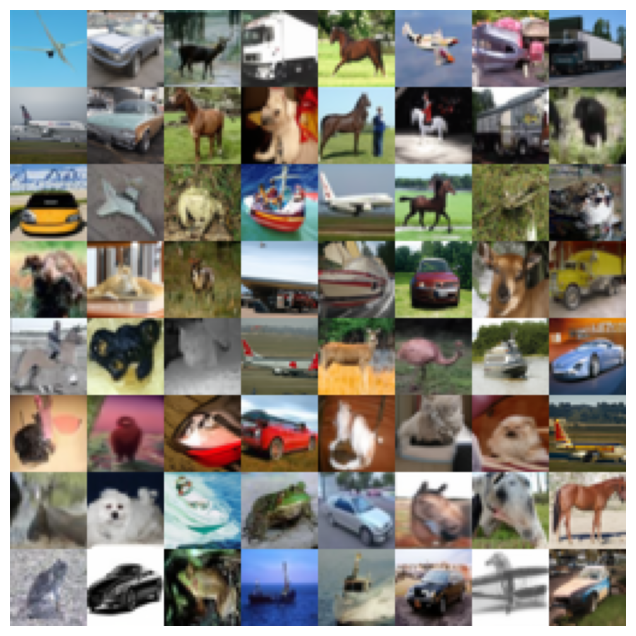

In [9]:
#@title PC sampling
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x, n = sampling_fn(score_model)
show_samples(x)

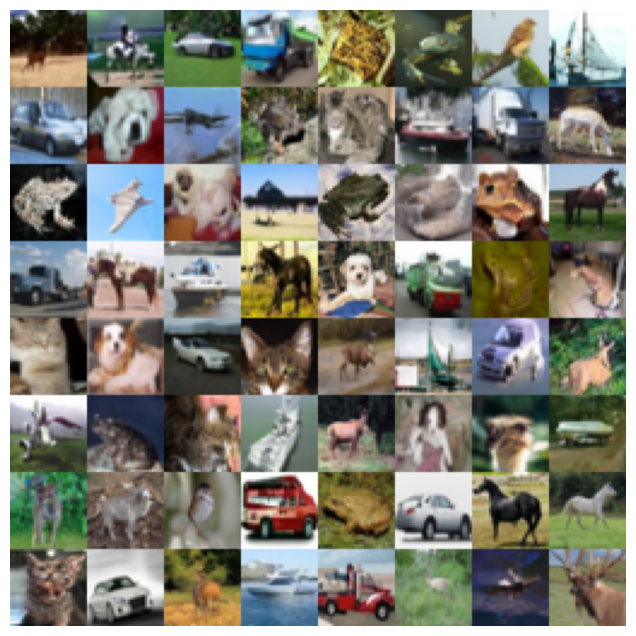

In [10]:
### just play
batch_size = 64
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
probability_flow = False

score_fn = mutils.get_score_fn(sde, score_model, train=False, continuous=config.training.continuous)
rsde = sde.reverse(score_fn, probability_flow)

with torch.no_grad():
    # Initial sample
    x = sde.prior_sampling(shape).to(config.device)
    timesteps = torch.linspace(sde.T, sampling_eps, sde.N, device=config.device)

    for i in range(sde.N):
        t = timesteps[i]
        vec_t = torch.ones(shape[0], device=t.device) * t

        # mean, std = sde.marginal_prob(x_clean, vec_t)
        # perturbed_data = mean + std[:, None, None, None] * torch.randn_like(x)
        # score = score_fn(perturbed_data, t)

        f, G = rsde.discretize(x, vec_t)
        z = torch.randn_like(x)
        x_mean = x - f
        x = x_mean + G[:, None, None, None] * z

    x = inverse_scaler(x_mean)
    
show_samples(x)

2022-10-17 23:58:24.089928: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


256.0


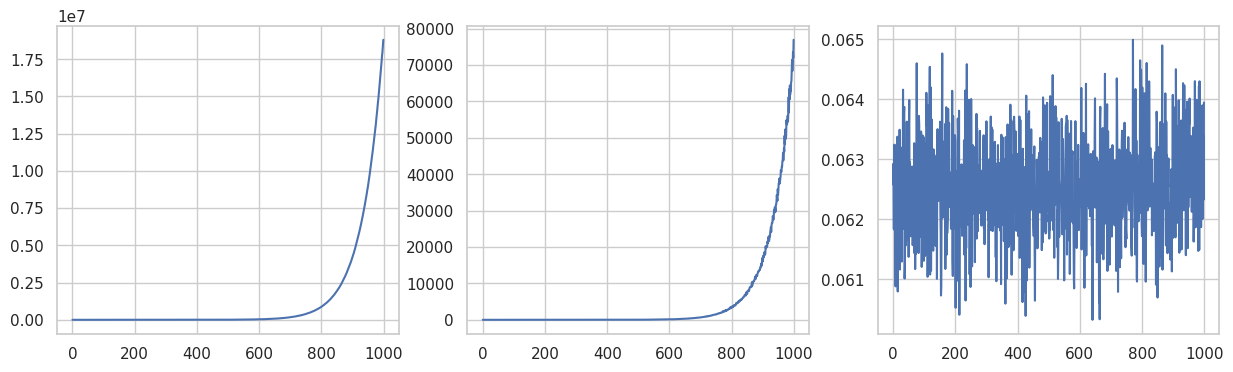

In [27]:
# plot the momentum of estimated scores

score_fn = mutils.get_score_fn(sde, score_model, train=False, continuous=config.training.continuous)
n_estimates = 1
config.eval.batch_size = 256

# Build data iterators
train_ds, _, _ = datasets.get_dataset(config,
                                      uniform_dequantization=config.data.uniform_dequantization,
                                      evaluation=True)
train_iter = iter(train_ds)

with torch.no_grad():
    timesteps = torch.linspace(sde.T, sampling_eps, sde.N, device=config.device)

    score_sum = torch.zeros(sde.N, channels, img_size, img_size).to(config.device)
    score_normsqr_sum = torch.zeros(sde.N).to(config.device)
    n_data = 0
    
    while 1:
        try:
            batch = next(train_iter)
        except StopIteration:
            break
        x = torch.from_numpy(batch['image']._numpy()).to(config.device).float()
        x = x.permute(0, 3, 1, 2)
        x = scaler(x)

        for i in range(sde.N):
            t = timesteps[i]
            vec_t = torch.ones(x.shape[0], device=t.device) * t 
            mean, std = sde.marginal_prob(x, vec_t)
            
            for _ in range(n_estimates):
                perturbed_data = mean + std[:, None, None, None] * torch.randn_like(x)
                score = score_fn(perturbed_data, vec_t)
                score_sum[i] += score.sum(0)
                score_normsqr_sum[i] += (score.flatten(1).norm(dim=1) ** 2).sum(0)
        
        n_data += n_estimates * x.shape[0]
        print(n_data / n_estimates)

        score_mean = score_sum / n_data
        score_mean_normsqr = score_mean.flatten(1).norm(dim=1) ** 2
        score_normsqr_mean = score_normsqr_sum / n_data
        ratio = (score_mean_normsqr / score_normsqr_mean).sqrt()

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        ax1.plot(range(sde.N), score_normsqr_mean.cpu().numpy())
        ax2.plot(range(sde.N), score_mean_normsqr.cpu().numpy())
        ax3.plot(range(sde.N), ratio.cpu().numpy())
        plt.show()
